#Description
This project explores various traditional machine learning and deep learning algorithms for the task of human activity recognition. A comparative analysis of both the performance and time complexity of each algorithm is provided.

#Mounting Google Drive

In [1]:
#Mounting Google Drive to get access to the dataset
from google.colab import drive
drive.mount('/content/gdrive/')

# This creates a symbolic link to the project folder
!ln -s /content/gdrive/MyDrive/ /drive

#List all the files in the folder
!ls /drive

Mounted at /content/gdrive/
'Human Activity Recognition (1).ipynb'	 WISDM_ar_v1.1_raw.txt
'WISDM_ar_latest (1).tar.gz'


#Import Libraries

In [2]:
#Libraries for data processing
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy import stats

#Libraries for performance evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
import time

#Libraries for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Loading

In [3]:
#Function to convert values to float
def float_conversion(x):
    try:
        return np.float(x)
    except:
        return np.nan

#Function to load the dataset file and name the columns
def load_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Removing ';'
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # Float Conversion
    df['z-axis'] = df['z-axis'].apply(float_conversion)

    df.dropna(axis=0, how='any', inplace=True)

    return df

In [4]:
# Loading dataset
df_dataset = load_data('/drive/WISDM_ar_v1.1_raw.txt')
# Print first five rows of the dataset
df_dataset.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


#Data Visualization

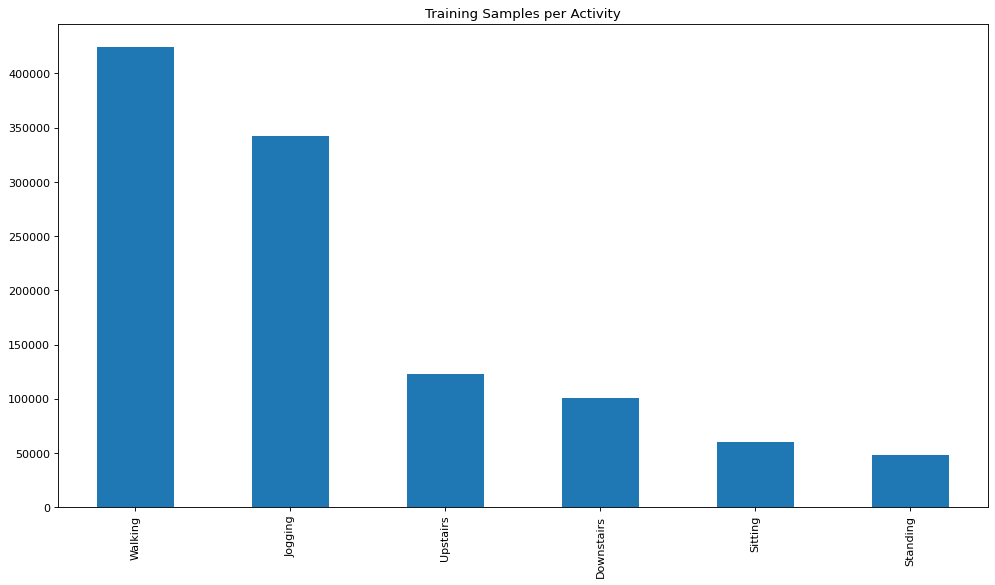

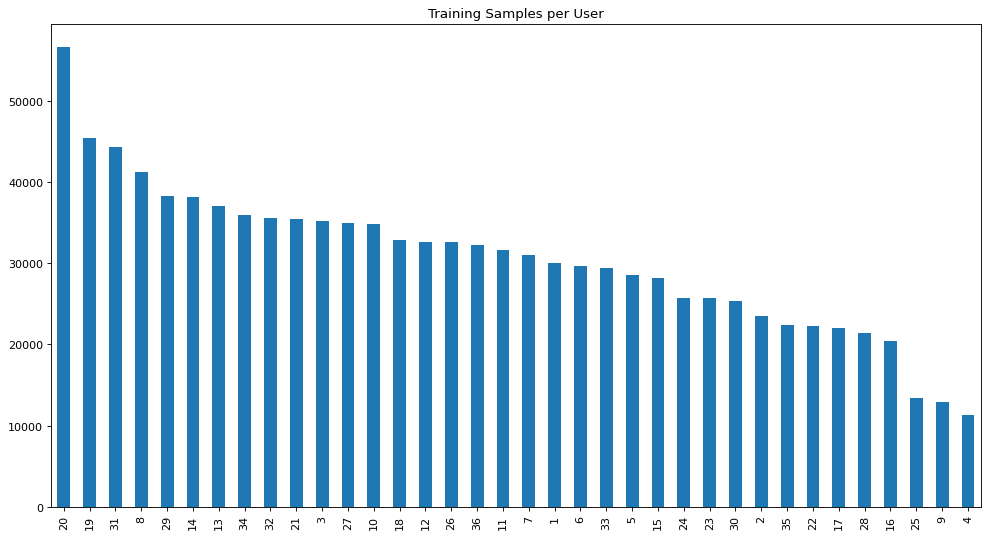

In [5]:
# Training samples per activity
plt.figure(figsize=(15, 8), dpi=80)
df_dataset['activity'].value_counts().plot(kind='bar',
                                   title='Training Samples per Activity')
plt.show()

#Training samples per user
plt.figure(figsize=(15, 8), dpi=80)
df_dataset['user-id'].value_counts().plot(kind='bar',
                                  title='Training Samples per User')
plt.show()

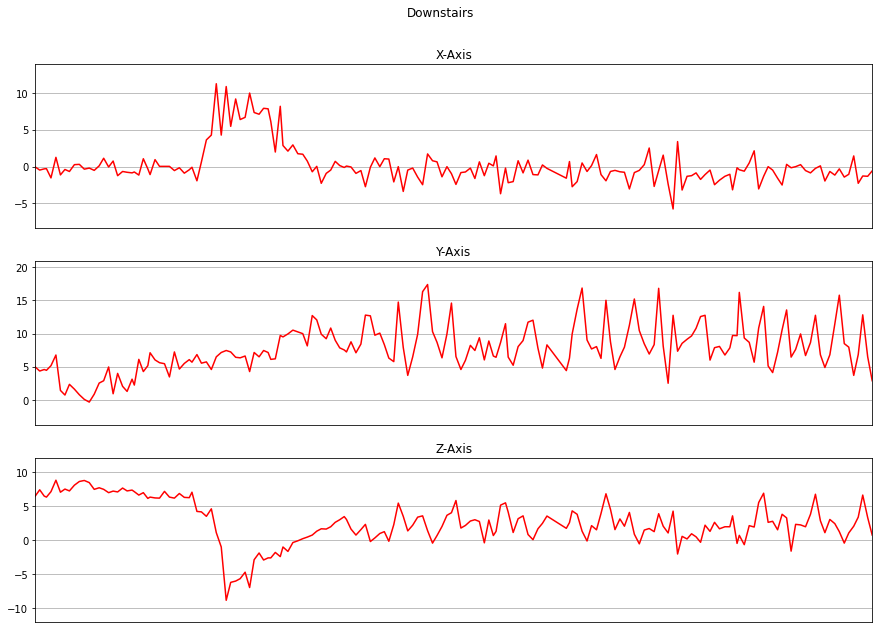

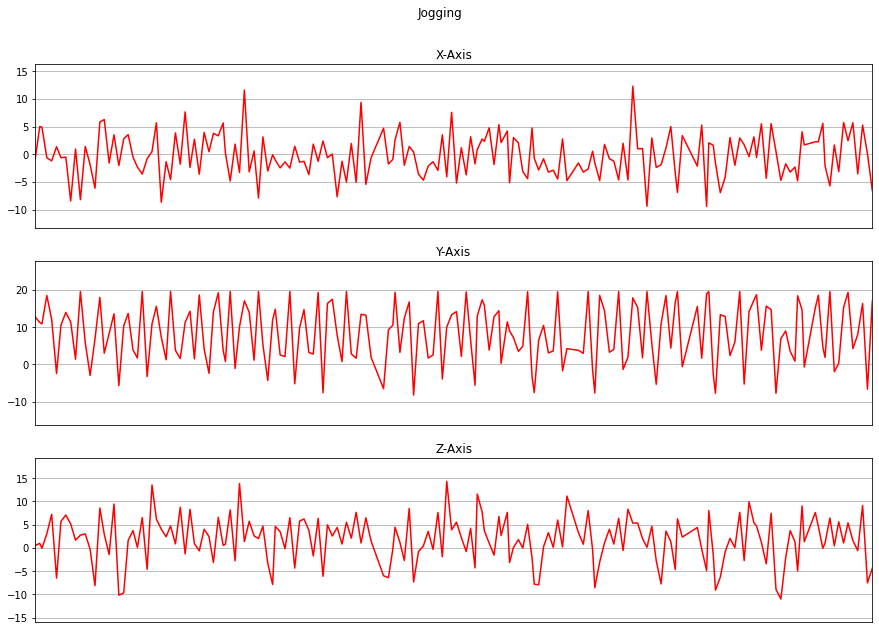

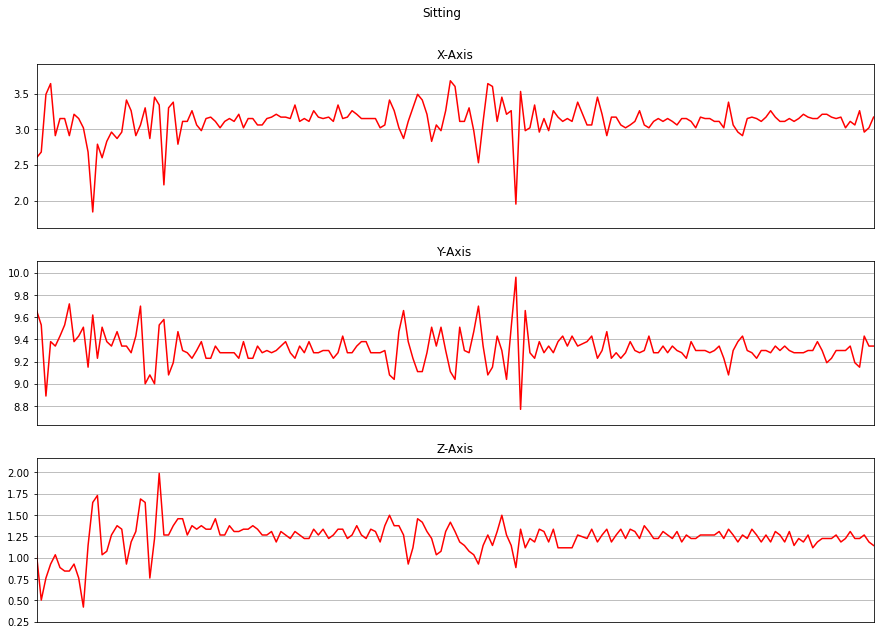

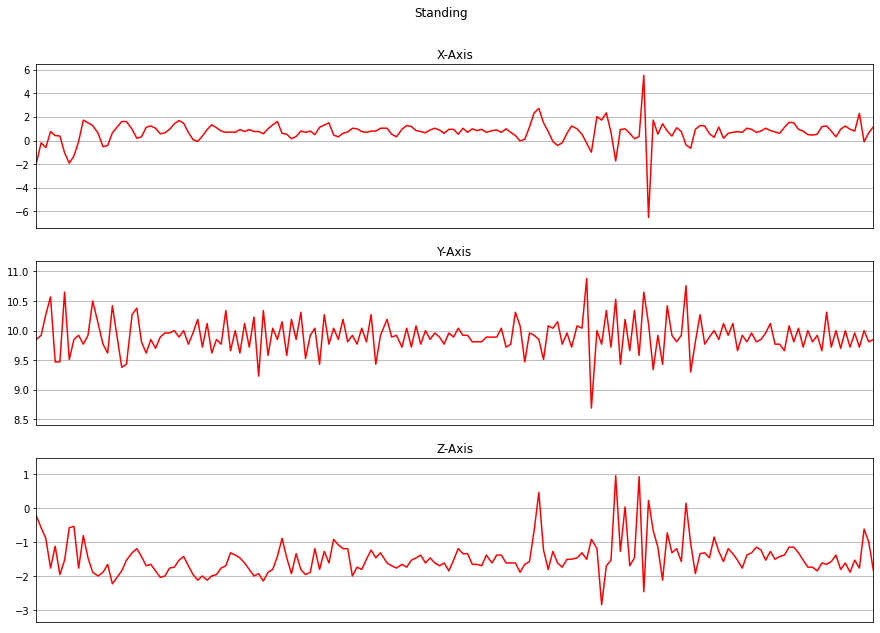

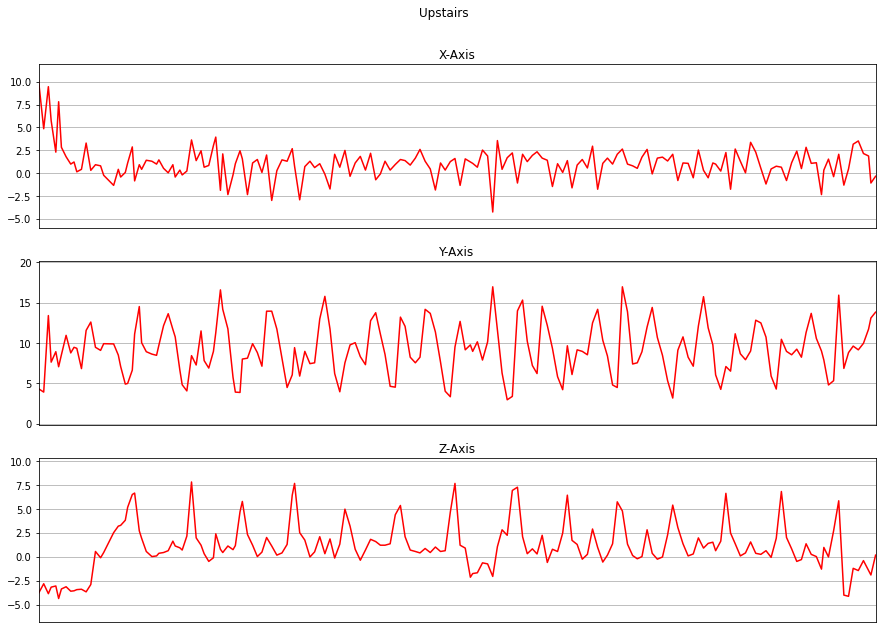

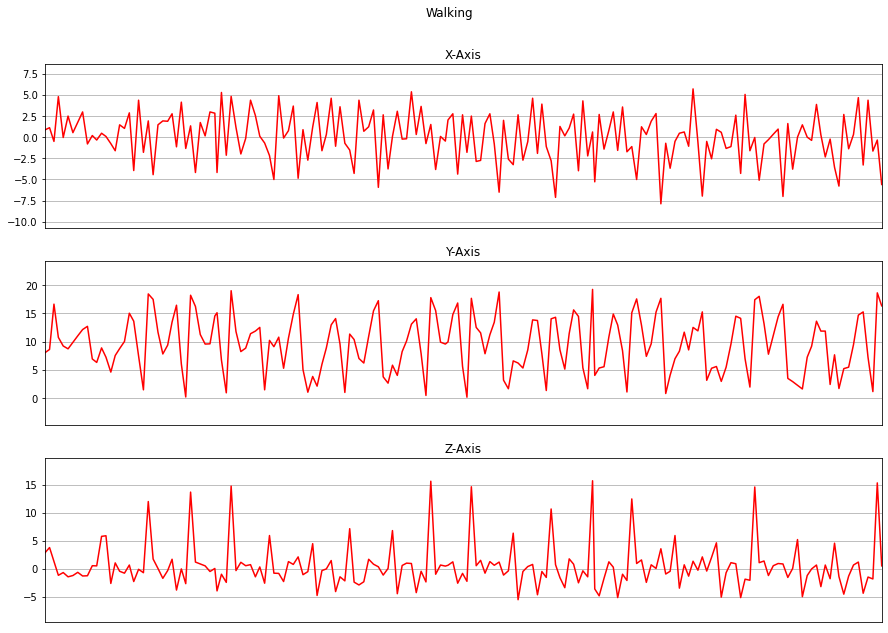

In [6]:
#Printing accelerometer pattern for different activities across the 3-axis
def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

for activity in np.unique(df_dataset['activity']):
    subset = df_dataset[df_dataset['activity'] == activity][:180]
    plot_activity(activity, subset)

#Data Preprocessing

In [7]:
# Label Vector Name
Act_Lab = 'EncodedActivity'
# Encoding the activity strings to numerics
enc = preprocessing.LabelEncoder()
# Appending the labeled activity column
df_dataset[Act_Lab] = enc.fit_transform(df_dataset['activity'].values.ravel())

In [ ]:
df_dataset

,user-id,activity,timestamp,x-axis,y-axis,z-axis,EncodedActivity
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


In [8]:
# Dataset training and test split
train_set = df_dataset[df_dataset['user-id'] <= 28]
test_set = df_dataset[df_dataset['user-id'] > 28]

In [9]:
# Feature Normalization

#Training Data
pd.options.mode.chained_assignment = None  # Avoid Warning
train_set['x-axis'] = train_set['x-axis'] / train_set['x-axis'].max()
train_set['y-axis'] = train_set['y-axis'] / train_set['y-axis'].max()
train_set['z-axis'] = train_set['z-axis'] / train_set['z-axis'].max()
# Rounding the decimal 
train_set = train_set.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

# Testing Data
test_set['x-axis'] = test_set['x-axis'] / test_set['x-axis'].max()
test_set['y-axis'] = test_set['y-axis'] / test_set['y-axis'].max()
test_set['z-axis'] = test_set['z-axis'] / test_set['z-axis'].max()
# Rounding the decimal
test_set = test_set.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [10]:
train_set.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,EncodedActivity
8489,17,Walking,57869902574000,0.0287,0.4894,-0.0271,5
8490,17,Walking,57870012316000,-0.0000,0.5084,-0.0292,5
8491,17,Walking,57870122301000,-0.0116,0.4914,-0.0354,5
8492,17,Walking,57870222246000,0.0075,0.5029,-0.0257,5
8493,17,Walking,57870332292000,0.0075,0.5063,-0.0313,5


In [11]:
# Labels for the activities
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
          
# Number of samples in one time slot
Time_window = 80
#Number of steps traversed before next time window begins
Time_step = 40

In [12]:
def window_labels_creation(d_frame, window, step, column_label):

    # Number of features
    num_feat = 3
    # Note: If below line is un-commented then there would be no overlap between the different windows
    # step = window
    windows = []
    labels = []
    for i in range(0, len(d_frame) - window, step):
        xs = d_frame['x-axis'].values[i: i + window]
        ys = d_frame['y-axis'].values[i: i + window]
        zs = d_frame['z-axis'].values[i: i + window]
        # Regain the frequently used label
        label = stats.mode(d_frame[column_label][i: i + window])[0][0]
        windows.append([xs, ys, zs])
        labels.append(label)

    # reshape the windows
    reshaped_windows = np.asarray(windows, dtype= np.float32).reshape(-1, window, num_feat)
    labels = np.asarray(labels)

    return reshaped_windows, labels

In [13]:
#Training Dataset Creation
x_train, y_train = window_labels_creation(train_set,
                                              Time_window,
                                              Time_step,
                                              Act_Lab)
#Testing Dataset Creation
x_test, y_test = window_labels_creation(test_set,
                                            Time_window,
                                            Time_step,
                                            Act_Lab)

In [14]:
#Converting the training and test set to float32
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

In [15]:
#Reshaping the 3-axis accelerometer data to one single column for tradational machine learning algorithms
#Getting the total number of windows and the 3-axis shape
num_win, num_dim = x_train.shape[1], x_train.shape[2]
#Defining the new input shape
input_shape = (num_win*num_dim)
#Reshaping the dataset
x_train_ml = x_train.reshape(x_train.shape[0], input_shape)
x_test_ml = x_test.reshape(x_test.shape[0], input_shape)

In [16]:
x_train_ml.shape

(20868, 240)

In [17]:
#This function is used for plotting the confusion matrix of the classified patterns
def plot_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(12, 8),dpi=100)
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Ground Truth')
    plt.xlabel('Predictions')
    plt.show()

#Traditional Machine Learning

#Support Vector Machine (SVM)

In [18]:
#Import the Classifier
from sklearn import svm            
svm_model = svm.SVC(kernel='rbf')

#Model Training  
svm_model.fit(x_train_ml,y_train)

#Model Delay Calculation
t1 = time.perf_counter()
svm_pred = svm_model.predict(x_test_ml)
t2 = time.perf_counter()

svm_time = t2-t1

svm_acc = accuracy_score(y_test, svm_pred)

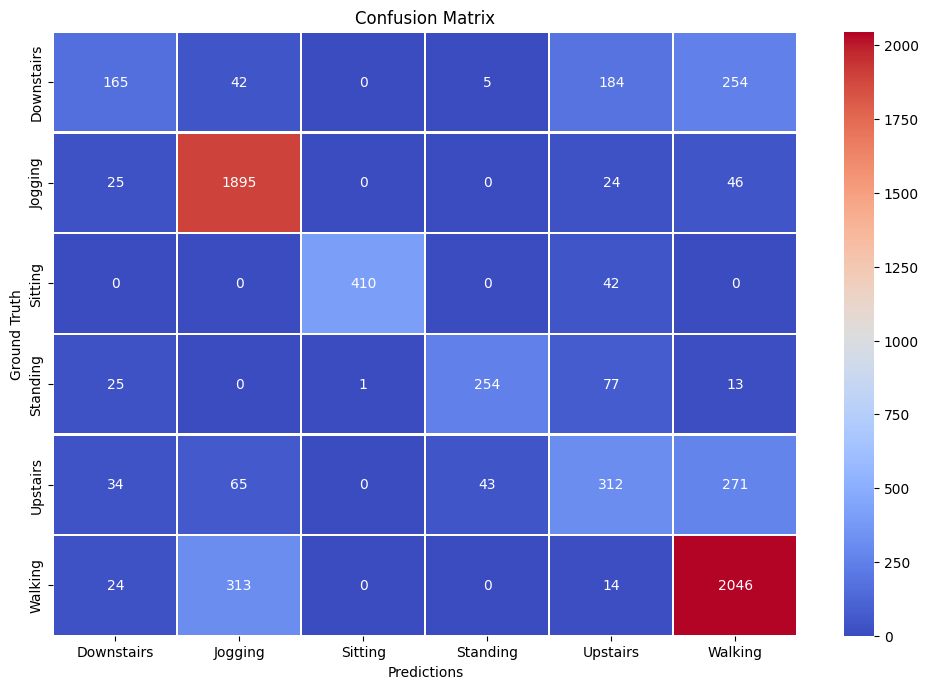

              precision    recall  f1-score   support

  Downstairs       0.60      0.25      0.36       650
     Jogging       0.82      0.95      0.88      1990
     Sitting       1.00      0.91      0.95       452
    Standing       0.84      0.69      0.76       370
    Upstairs       0.48      0.43      0.45       725
     Walking       0.78      0.85      0.81      2397

    accuracy                           0.77      6584
   macro avg       0.75      0.68      0.70      6584
weighted avg       0.76      0.77      0.76      6584



In [19]:
# Algorithm Performance

#Confusion Matrix
plot_confusion_matrix(y_test, svm_pred)

#Classification Details
print(classification_report(y_test, svm_pred, target_names=[l for l in LABELS]))

#K-Nearest Neighbor (KNN)

In [20]:
#Model Import
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)

#Model Training
knn_model.fit(x_train_ml, y_train)


#Model Delay Calculation
t1 = time.perf_counter()
knn_pred = knn_model.predict(x_test_ml)
t2 = time.perf_counter()

knn_time = t2-t1

knn_acc = accuracy_score(y_test, knn_pred)

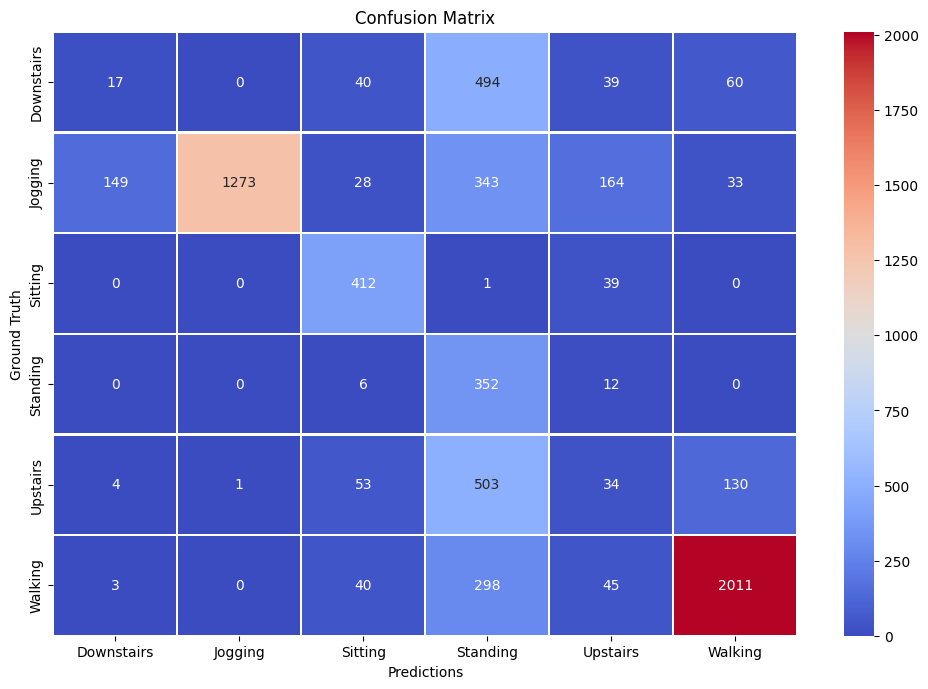

              precision    recall  f1-score   support

  Downstairs       0.10      0.03      0.04       650
     Jogging       1.00      0.64      0.78      1990
     Sitting       0.71      0.91      0.80       452
    Standing       0.18      0.95      0.30       370
    Upstairs       0.10      0.05      0.06       725
     Walking       0.90      0.84      0.87      2397

    accuracy                           0.62      6584
   macro avg       0.50      0.57      0.48      6584
weighted avg       0.71      0.62      0.63      6584



In [21]:
# Algorithm Performance

#Confusion Matrix
plot_confusion_matrix(y_test, knn_pred)

#Classification Details
print(classification_report(y_test, knn_pred, target_names=[l for l in LABELS]))

#Time Series Forest

In [22]:
#Installing Pyts for Time Series Forest Algorithm
!pip install pyts

     |████████████████████████████████| 2.5 MB 5.4 MB/s 


In [23]:
#Model Import
from pyts.classification import TimeSeriesForest
tsf_model = TimeSeriesForest(random_state=43)

#Model Training
tsf_model.fit(x_train_ml, y_train)

#Model Delay Calculation
t1 = time.perf_counter()
tsf_pred = tsf_model.predict(x_test_ml)
t2 = time.perf_counter()

tsf_time = t2-t1

tsf_acc = accuracy_score(y_test, tsf_pred)

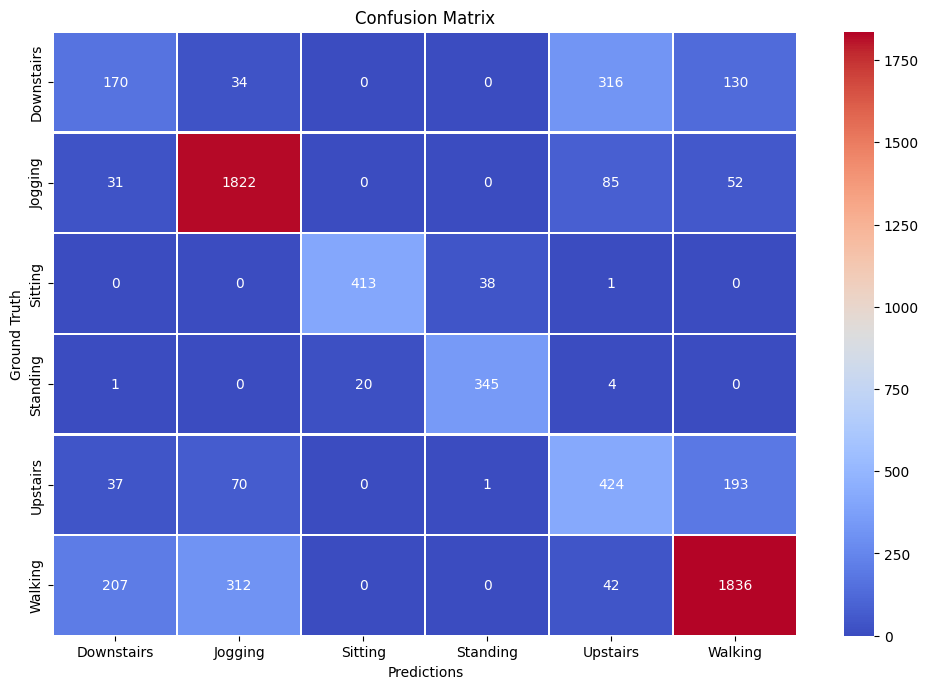

              precision    recall  f1-score   support

  Downstairs       0.38      0.26      0.31       650
     Jogging       0.81      0.92      0.86      1990
     Sitting       0.95      0.91      0.93       452
    Standing       0.90      0.93      0.92       370
    Upstairs       0.49      0.58      0.53       725
     Walking       0.83      0.77      0.80      2397

    accuracy                           0.76      6584
   macro avg       0.73      0.73      0.72      6584
weighted avg       0.76      0.76      0.76      6584



In [24]:
# Algorithm Performance

#Confusion Matrix
plot_confusion_matrix(y_test, tsf_pred)

#Classification Details
print(classification_report(y_test, tsf_pred, target_names=[l for l in LABELS]))

Text(0.5, 1.0, 'Algorithms Accuracy Barchart')

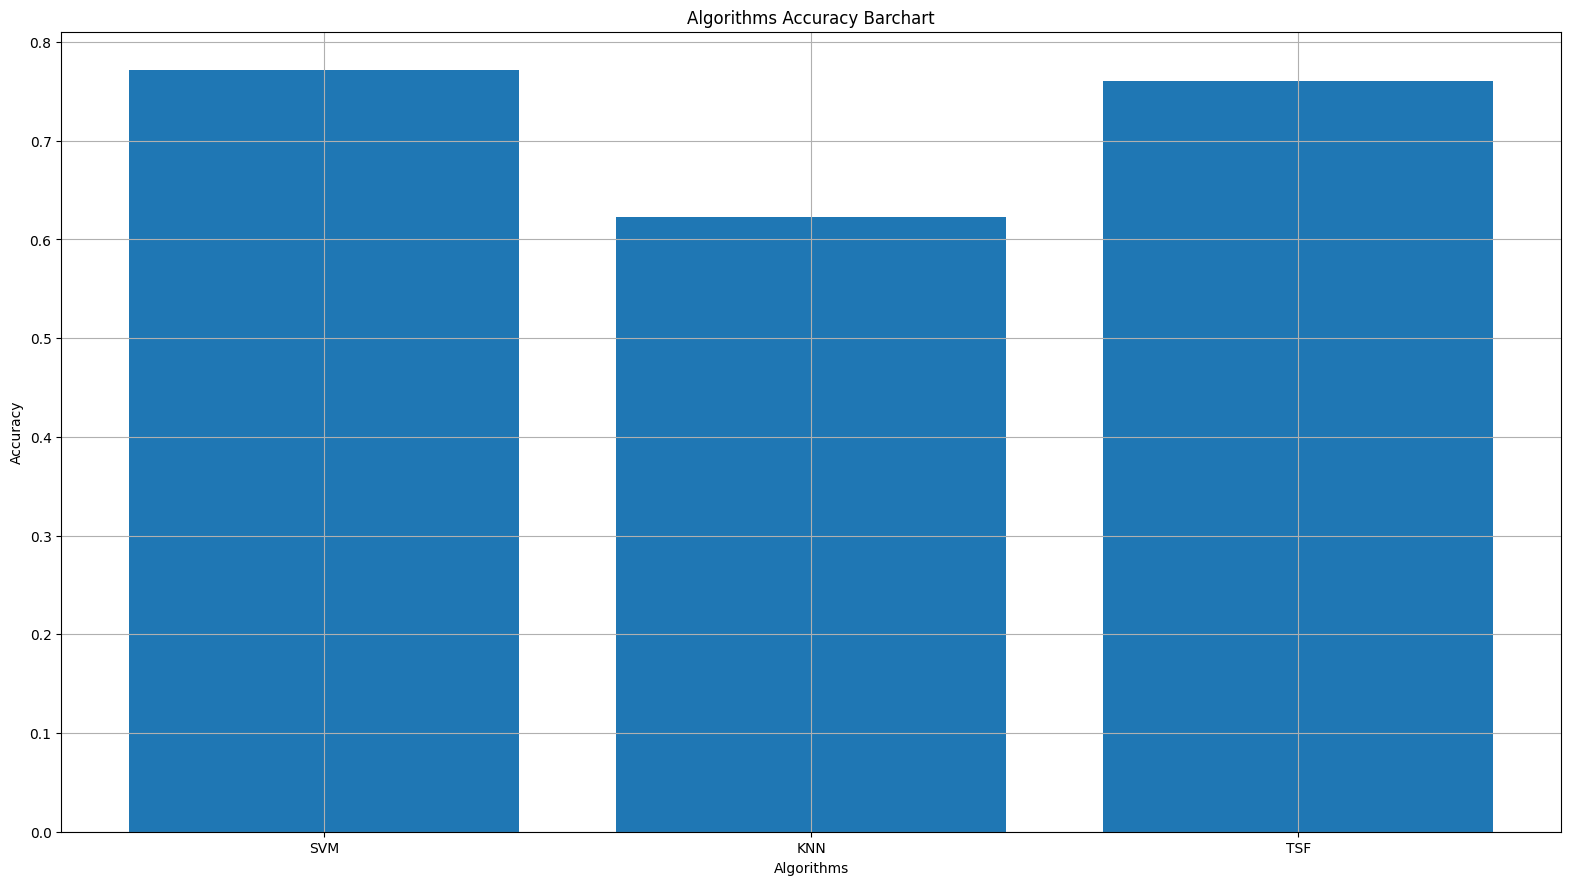

In [25]:
#Comparing Algorithms Accuracies using a barchart
fig = plt.figure(figsize=(15, 8), dpi=100)
ax = fig.add_axes([1,1,1,1])
Algos = ['SVM','KNN','TSF']
Accs = [svm_acc,knn_acc,tsf_acc]
ax.bar(Algos,Accs);
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Algorithms Accuracy Barchart')

Text(0.5, 1.0, 'Algorithms Inference Time')

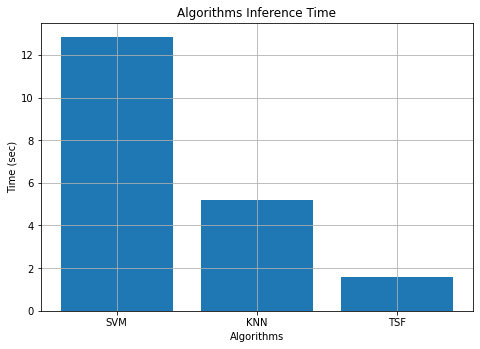

In [26]:
#Comparing Algorithms Inference time using a barchart
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
Algos = ['SVM','KNN','TSF']
Accs = [svm_time,knn_time,tsf_time]
ax.bar(Algos,Accs);
plt.xlabel('Algorithms')
plt.ylabel('Time (sec)')
plt.grid()
plt.title('Algorithms Inference Time')

In [27]:
#Comparing algorithms accuracies and time using a table
from tabulate import tabulate      #For displaying results
table = [['Algorithm', 'Accuracy', 'Inference Time (sec)'], ['SVM', str(svm_acc),str(svm_time)], ['KNN', str(knn_acc),str(knn_time)], ['TSF', str(tsf_acc),str(tsf_time)]]

print(tabulate(table, headers='firstrow', tablefmt='grid'))

+-------------+------------+------------------------+
| Algorithm   |   Accuracy |   Inference Time (sec) |
+=============+============+========================+
| SVM         |   0.771871 |               12.8618  |
+-------------+------------+------------------------+
| KNN         |   0.62257  |                5.17407 |
+-------------+------------+------------------------+
| TSF         |   0.760936 |                1.60039 |
+-------------+------------+------------------------+


#Deep Learning
##Simple Artificial Neural Network (ANN)

In [28]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model 

In [29]:
#Number of output classes
num_classes = enc.classes_.size

#One Hot Encoding of the Training Labels for Deep Learning Models
y_train_hot = np_utils.to_categorical(y_train, num_classes)
#One Hot Encoding of the Test labels
y_test_hot = np_utils.to_categorical(y_test, num_classes)

# Input and output dimensions
n_features = x_train.shape[2]
n_outputs = y_train_hot.shape[1]

In [30]:
# Tuning Parameters
Batches = 400
Epochs = 100

In [31]:
dnn_model = Sequential()
dnn_model.add(Dense(50, activation='relu', input_shape = (Time_window,n_features), kernel_regularizer=keras.regularizers.l1_l2(l1=0.02, l2=0.02)))
dnn_model.add(Dropout(0.3))
dnn_model.add(Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.02, l2=0.02)))
dnn_model.add(Flatten())
dnn_model.add(Dense(num_classes, activation='softmax'))


#Model Compilation. Setting Loss Function, Optimizer and Performance Metrics
dnn_model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['acc'])

# Model Training
dnn_hist = dnn_model.fit(x_train,
                      y_train_hot,
                      batch_size=Batches,
                      epochs=Epochs,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/100
42/42 [==============================] - 3s 21ms/step - loss: 7.8665 - acc: 0.5626 - val_loss: 6.3947 - val_acc: 0.7144
Epoch 2/100
42/42 [==============================] - 1s 12ms/step - loss: 5.4505 - acc: 0.6850 - val_loss: 4.4225 - val_acc: 0.7408
Epoch 3/100
42/42 [==============================] - 1s 12ms/step - loss: 3.7667 - acc: 0.7012 - val_loss: 3.0322 - val_acc: 0.7585
Epoch 4/100
42/42 [==============================] - 0s 12ms/step - loss: 2.5979 - acc: 0.7074 - val_loss: 2.0925 - val_acc: 0.7707
Epoch 5/100
42/42 [==============================] - 1s 12ms/step - loss: 1.8297 - acc: 0.7144 - val_loss: 1.4972 - val_acc: 0.7808
Epoch 6/100
42/42 [==============================] - 1s 12ms/step - loss: 1.3722 - acc: 0.7156 - val_loss: 1.1915 - val_acc: 0.7851
Epoch 7/100
42/42 [==============================] - 1s 12ms/step - loss: 1.1517 - acc: 0.7331 - val_loss: 1.0643 - val_acc: 0.7964
Epoch 8/100
42/42 [==============================] - 1s 12ms/step - loss: 1.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80, 50)            200       
                                                                 
 dropout (Dropout)           (None, 80, 50)            0         
                                                                 
 dense_1 (Dense)             (None, 80, 50)            2550      
                                                                 
 flatten (Flatten)           (None, 4000)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 24006     
                                                                 
Total params: 26,756
Trainable params: 26,756
Non-trainable params: 0
_________________________________________________________________


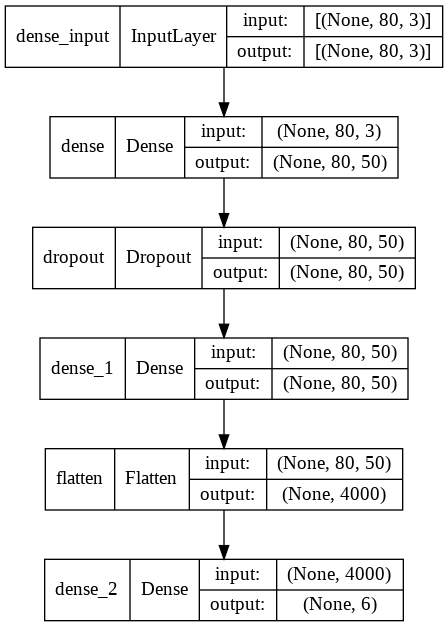

In [32]:
#Model summary
dnn_model.summary()

#Plotting the model
plot_model(dnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

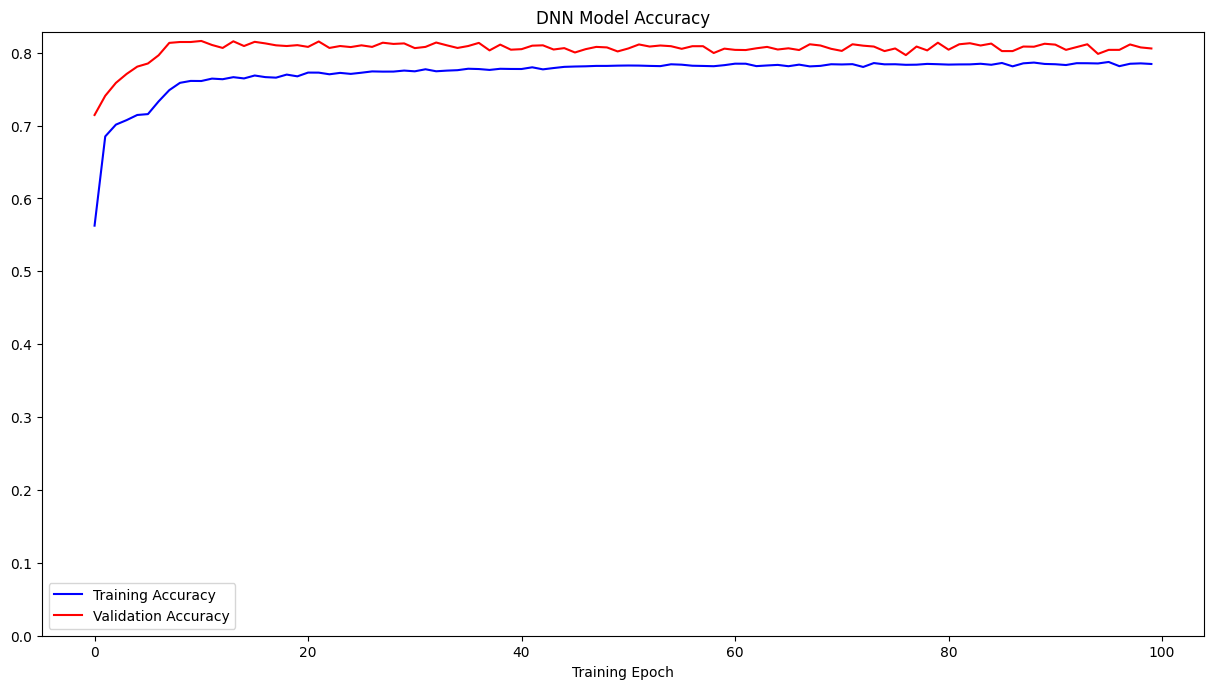

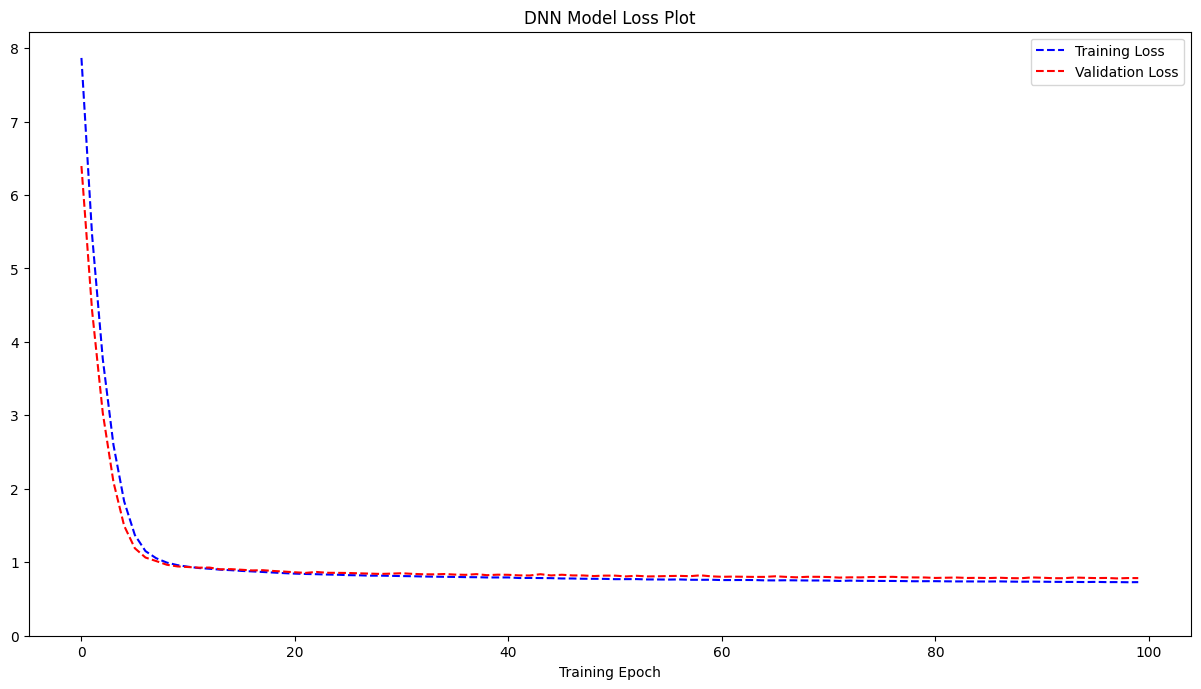

In [33]:
plt.figure(figsize=(15, 8), dpi=100)
plt.plot(dnn_hist.history['acc'], 'b', label='Training Accuracy')
plt.plot(dnn_hist.history['val_acc'], 'r', label='Validation Accuracy')
plt.title('DNN Model Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

plt.figure(figsize=(15, 8), dpi=100)
plt.plot(dnn_hist.history['loss'], 'b--', label='Training Loss')
plt.plot(dnn_hist.history['val_loss'], 'r--', label='Validation Loss')
plt.title('DNN Model Loss Plot')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

206/206 [==============================] - 1s 5ms/step - loss: 0.9133 - acc: 0.7292

Test Accuracy: 0.73

Test Loss: 0.91


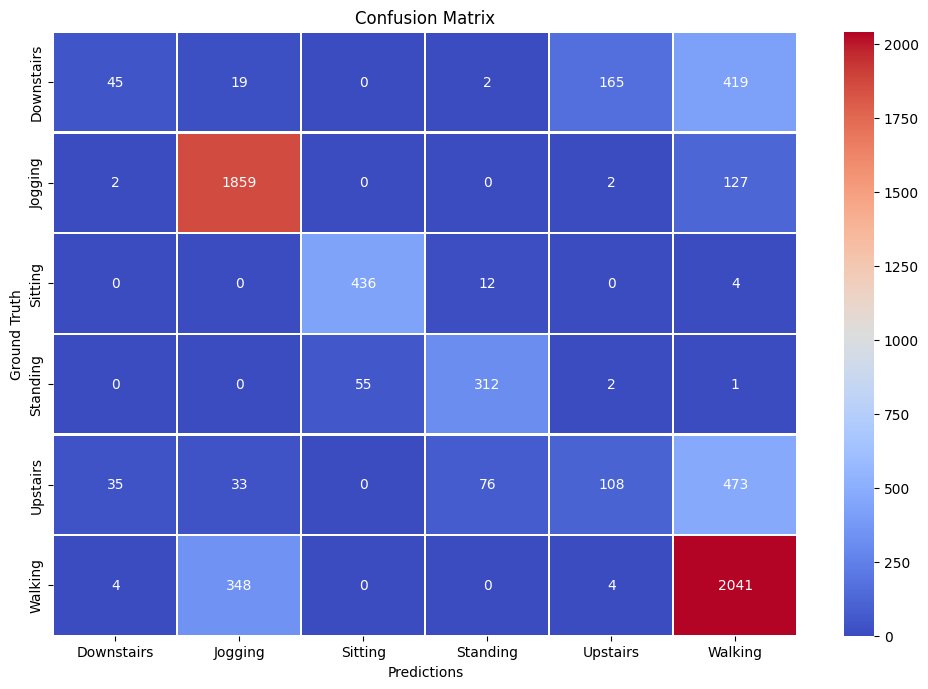

              precision    recall  f1-score   support

         0.0       0.52      0.07      0.12       650
         1.0       0.82      0.93      0.88      1990
         2.0       0.89      0.96      0.92       452
         3.0       0.78      0.84      0.81       370
         4.0       0.38      0.15      0.21       725
         5.0       0.67      0.85      0.75      2397

    accuracy                           0.73      6584
   macro avg       0.68      0.64      0.62      6584
weighted avg       0.69      0.73      0.68      6584



In [34]:
dnn_performance = dnn_model.evaluate(x_test, y_test_hot, verbose=1)

print('\nTest Accuracy: %0.2f' % dnn_performance[1])
print('\nTest Loss: %0.2f' % dnn_performance[0])


#Model Delay Calculation
t1 = time.perf_counter()
# Predict and choose the class with highest probability
dnn_y_pred_test = np.argmax(dnn_model.predict(x_test), axis=1)
t2 = time.perf_counter()

dnn_time = t2-t1

plot_confusion_matrix(y_test, dnn_y_pred_test)
print(classification_report(y_test, dnn_y_pred_test))

##Convolutional Neural Network (CNN)

In [35]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(Time_window,n_features)))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.01)))
cnn_model.add(Dense(n_outputs, activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_hist = cnn_model.fit(x_train, y_train_hot, validation_split=0.2, 
                    epochs=Epochs, batch_size=Batches, verbose=1)

Epoch 1/100
42/42 [==============================] - 9s 22ms/step - loss: 140.4450 - accuracy: 0.4225 - val_loss: 19.3785 - val_accuracy: 0.4887
Epoch 2/100
42/42 [==============================] - 0s 9ms/step - loss: 8.6108 - accuracy: 0.3891 - val_loss: 4.9267 - val_accuracy: 0.4382
Epoch 3/100
42/42 [==============================] - 0s 10ms/step - loss: 4.7549 - accuracy: 0.3824 - val_loss: 4.5756 - val_accuracy: 0.4382
Epoch 4/100
42/42 [==============================] - 0s 9ms/step - loss: 4.6474 - accuracy: 0.3824 - val_loss: 4.5103 - val_accuracy: 0.4382
Epoch 5/100
42/42 [==============================] - 0s 9ms/step - loss: 4.6332 - accuracy: 0.3824 - val_loss: 4.5147 - val_accuracy: 0.4382
Epoch 6/100
42/42 [==============================] - 0s 9ms/step - loss: 4.6253 - accuracy: 0.3824 - val_loss: 4.5005 - val_accuracy: 0.4382
Epoch 7/100
42/42 [==============================] - 0s 9ms/step - loss: 4.6214 - accuracy: 0.3824 - val_loss: 4.5096 - val_accuracy: 0.4382
Epoch 8/

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 78, 64)            640       
                                                                 
 flatten_1 (Flatten)         (None, 4992)              0         
                                                                 
 dense_3 (Dense)             (None, 50)                249650    
                                                                 
 dense_4 (Dense)             (None, 6)                 306       
                                                                 
Total params: 250,596
Trainable params: 250,596
Non-trainable params: 0
_________________________________________________________________


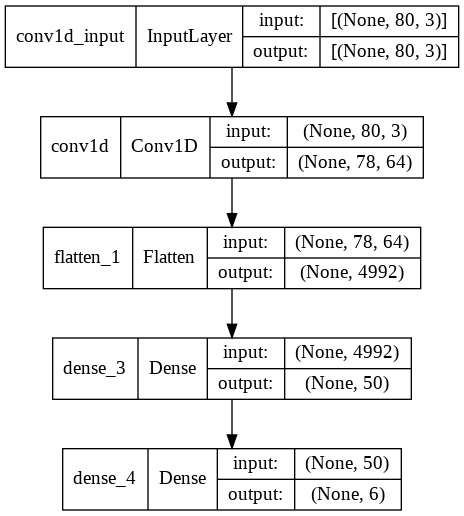

In [36]:
#Model summary
cnn_model.summary()

#Plotting the model
plot_model(cnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

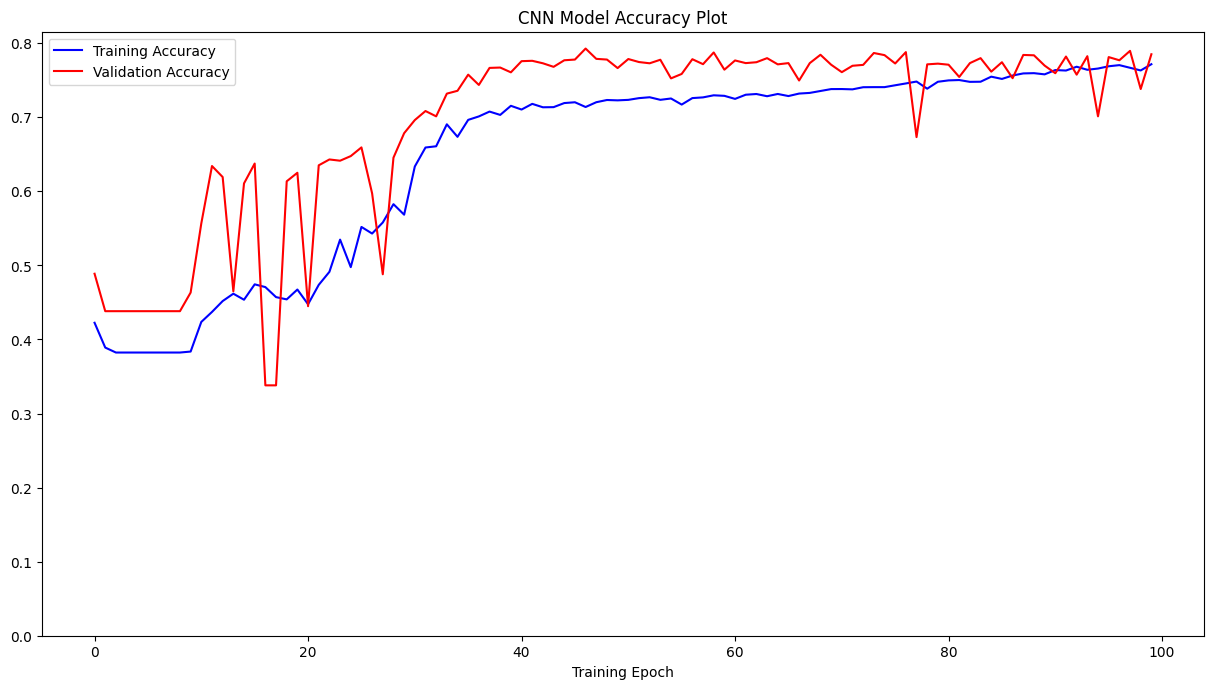

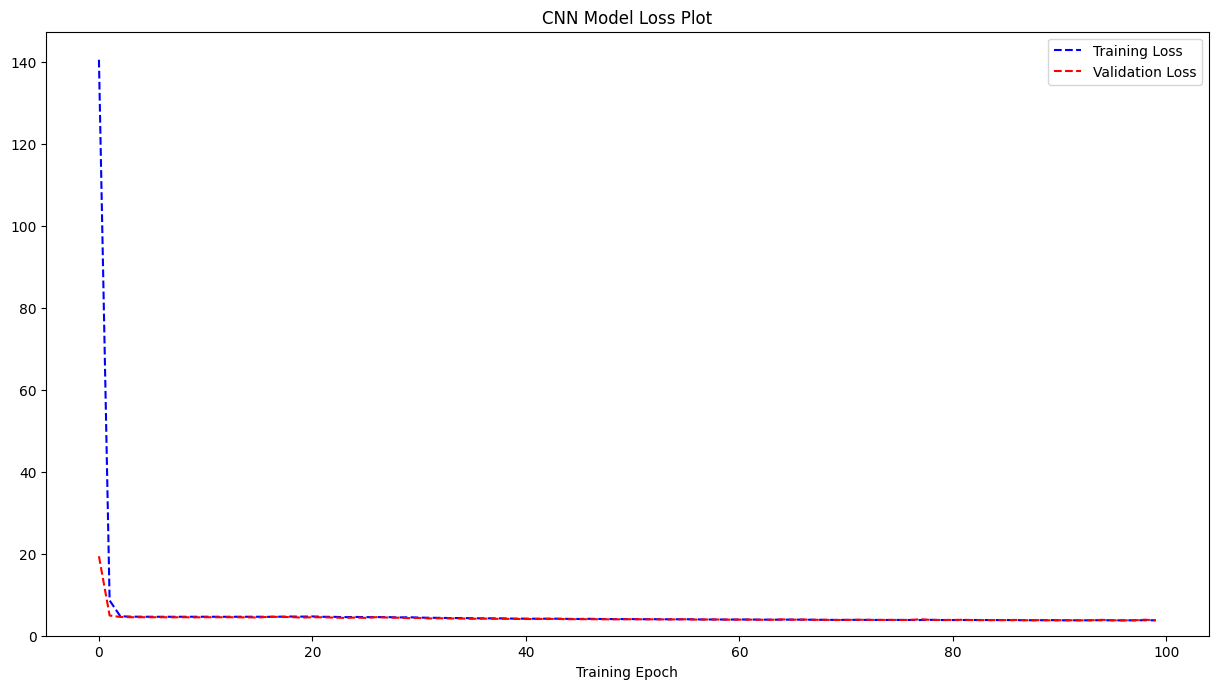

In [37]:
plt.figure(figsize=(15, 8), dpi=100)
plt.plot(cnn_hist.history['accuracy'], 'b', label='Training Accuracy')
plt.plot(cnn_hist.history['val_accuracy'], 'r', label='Validation Accuracy')
plt.title('CNN Model Accuracy Plot')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

plt.figure(figsize=(15, 8), dpi=100)
plt.plot(cnn_hist.history['loss'], 'b--', label='Training Loss')
plt.plot(cnn_hist.history['val_loss'], 'r--', label='Validation Loss')
plt.title('CNN Model Loss Plot')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

206/206 [==============================] - 1s 4ms/step - loss: 3.8930 - accuracy: 0.7079

Test Accuracy: 0.71

Test Loss: 3.89


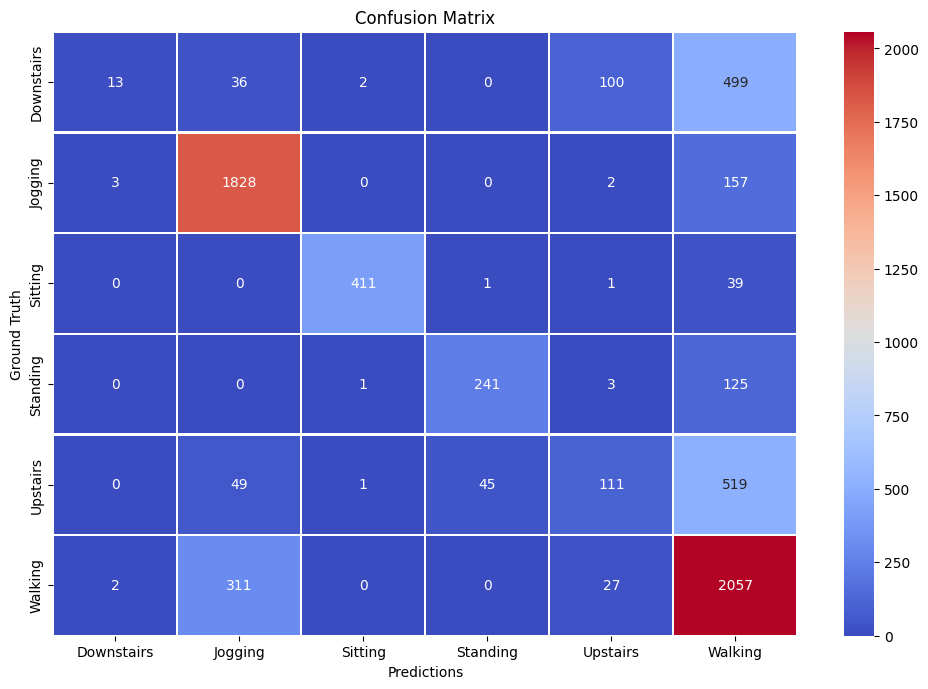

              precision    recall  f1-score   support

         0.0       0.72      0.02      0.04       650
         1.0       0.82      0.92      0.87      1990
         2.0       0.99      0.91      0.95       452
         3.0       0.84      0.65      0.73       370
         4.0       0.45      0.15      0.23       725
         5.0       0.61      0.86      0.71      2397

    accuracy                           0.71      6584
   macro avg       0.74      0.59      0.59      6584
weighted avg       0.71      0.71      0.66      6584



In [38]:
cnn_performance = cnn_model.evaluate(x_test, y_test_hot, verbose=1)

print('\nTest Accuracy: %0.2f' % cnn_performance[1])
print('\nTest Loss: %0.2f' % cnn_performance[0])

#Model Delay Calculation
t1 = time.perf_counter()
# Predict and choose the class with highest probability
cnn_y_pred_test = np.argmax(cnn_model.predict(x_test), axis=1)
t2 = time.perf_counter()

cnn_time = t2 - t1

plot_confusion_matrix(y_test, cnn_y_pred_test)
print(classification_report(y_test, cnn_y_pred_test))


## Long Short Term Memory (LSTM)

In [39]:
lstm_model = Sequential()
lstm_model.add(LSTM(20, input_shape=(Time_window,n_features), return_sequences=False))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(n_outputs, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_hist = lstm_model.fit(x_train, y_train_hot, validation_split=0.2, 
                    epochs=Epochs, batch_size=Epochs, verbose=1)

Epoch 1/100
167/167 [==============================] - 6s 21ms/step - loss: 1.4329 - accuracy: 0.4665 - val_loss: 1.2519 - val_accuracy: 0.6040
Epoch 2/100
167/167 [==============================] - 3s 17ms/step - loss: 1.0296 - accuracy: 0.6805 - val_loss: 0.8721 - val_accuracy: 0.7566
Epoch 3/100
167/167 [==============================] - 3s 17ms/step - loss: 0.8899 - accuracy: 0.7121 - val_loss: 0.8373 - val_accuracy: 0.7566
Epoch 4/100
167/167 [==============================] - 3s 17ms/step - loss: 0.8230 - accuracy: 0.7237 - val_loss: 0.8337 - val_accuracy: 0.7470
Epoch 5/100
167/167 [==============================] - 3s 17ms/step - loss: 0.7704 - accuracy: 0.7415 - val_loss: 0.9478 - val_accuracy: 0.7147
Epoch 6/100
167/167 [==============================] - 3s 17ms/step - loss: 0.7482 - accuracy: 0.7501 - val_loss: 0.8245 - val_accuracy: 0.7523
Epoch 7/100
167/167 [==============================] - 3s 17ms/step - loss: 0.6965 - accuracy: 0.7666 - val_loss: 0.8317 - val_accuracy:

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1920      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 126       
                                                                 
Total params: 2,046
Trainable params: 2,046
Non-trainable params: 0
_________________________________________________________________


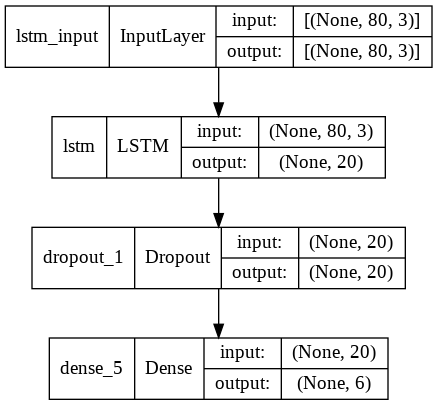

In [40]:
#Model summary
lstm_model.summary()

#Plotting the model
plot_model(lstm_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

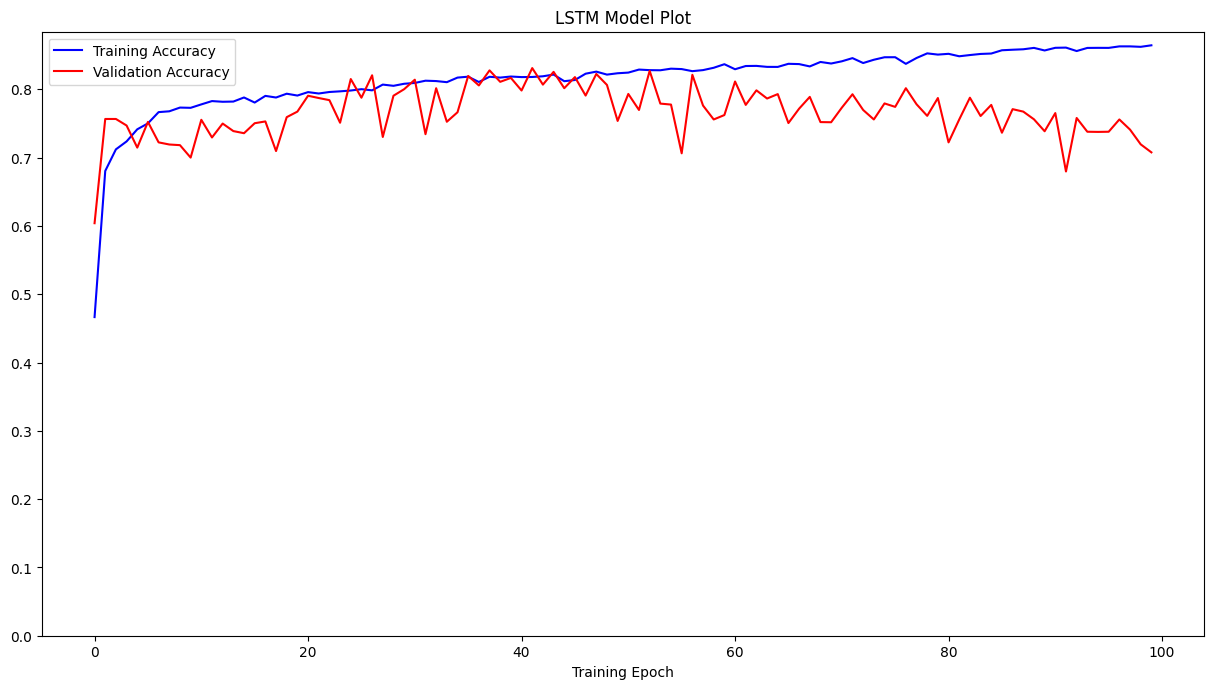

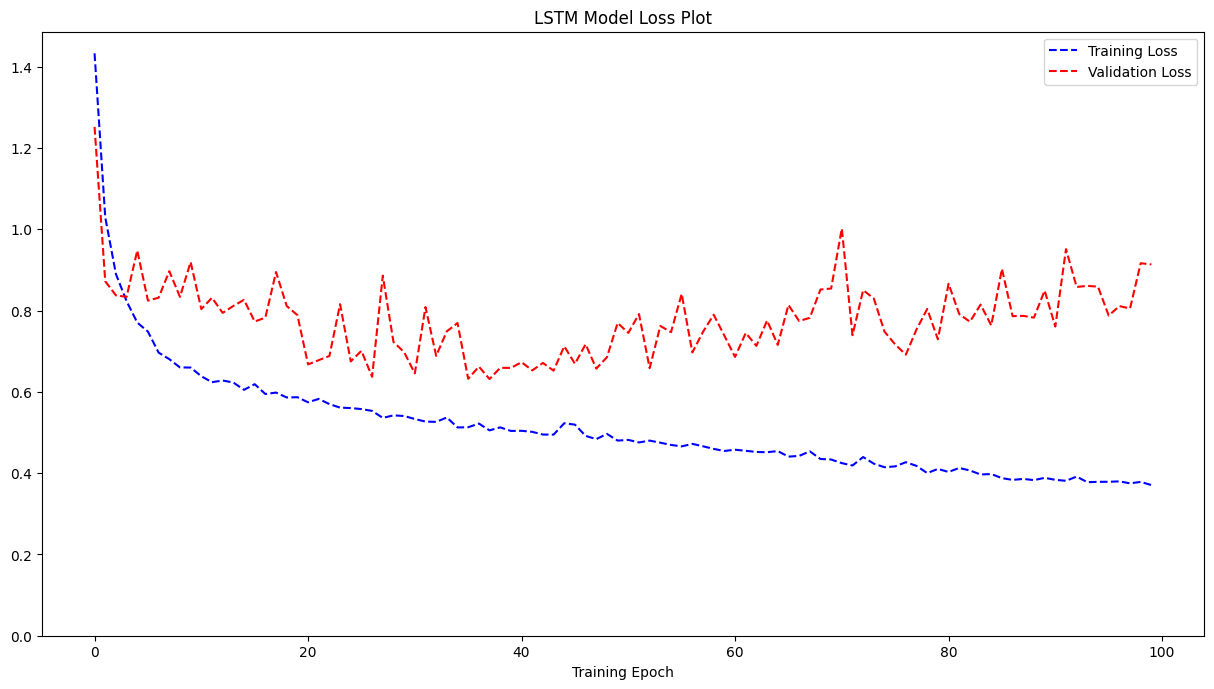

In [41]:
plt.figure(figsize=(15, 8), dpi=100)
plt.plot(lstm_hist.history['accuracy'], 'b', label='Training Accuracy')
plt.plot(lstm_hist.history['val_accuracy'], 'r', label='Validation Accuracy')
plt.title('LSTM Model Plot')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


plt.figure(figsize=(15, 8), dpi=100)
plt.plot(lstm_hist.history['loss'], 'b--', label='Training Loss')
plt.plot(lstm_hist.history['val_loss'], 'r--', label='Validation Loss')
plt.title('LSTM Model Loss Plot')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

206/206 [==============================] - 2s 8ms/step - loss: 1.0491 - accuracy: 0.7067

Test Accuracy: 0.71

Test Loss: 1.05


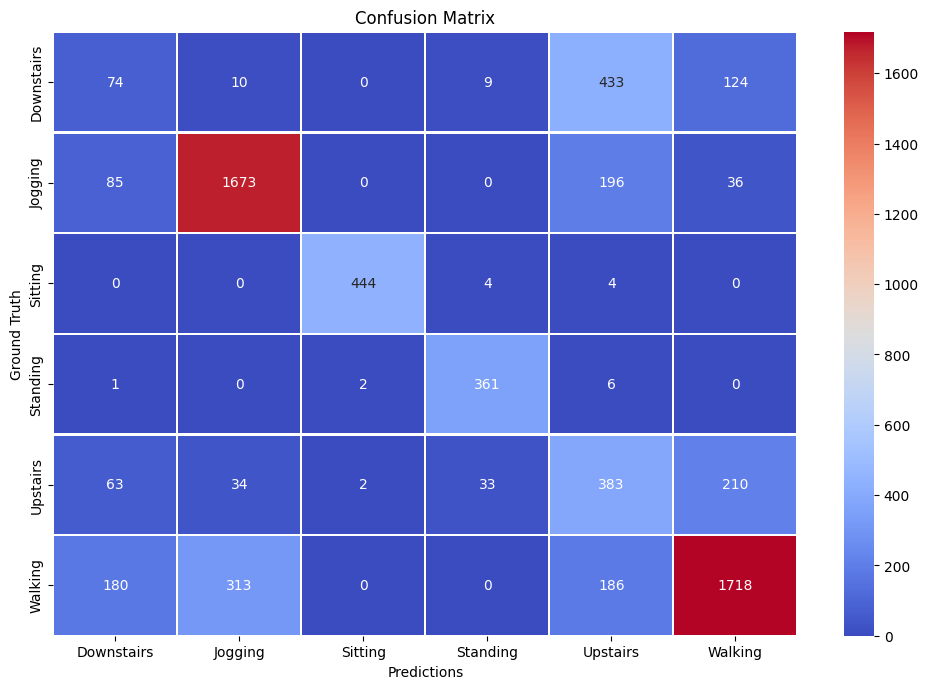

              precision    recall  f1-score   support

         0.0       0.18      0.11      0.14       650
         1.0       0.82      0.84      0.83      1990
         2.0       0.99      0.98      0.99       452
         3.0       0.89      0.98      0.93       370
         4.0       0.32      0.53      0.40       725
         5.0       0.82      0.72      0.77      2397

    accuracy                           0.71      6584
   macro avg       0.67      0.69      0.68      6584
weighted avg       0.72      0.71      0.71      6584



In [42]:
lstm_performance = lstm_model.evaluate(x_test, y_test_hot, verbose=1)

print('\nTest Accuracy: %0.2f' % lstm_performance[1])
print('\nTest Loss: %0.2f' % lstm_performance[0])

t1 = time.perf_counter()
# Predict and choose the class with highest probability
lstm_y_pred_test = np.argmax(lstm_model.predict(x_test), axis=1)
t2 = time.perf_counter()

lstm_time = t2 - t1

plot_confusion_matrix(y_test, lstm_y_pred_test)
print(classification_report(y_test, lstm_y_pred_test))

Text(0.5, 1.0, 'Algorithms Accuracy Barchart')

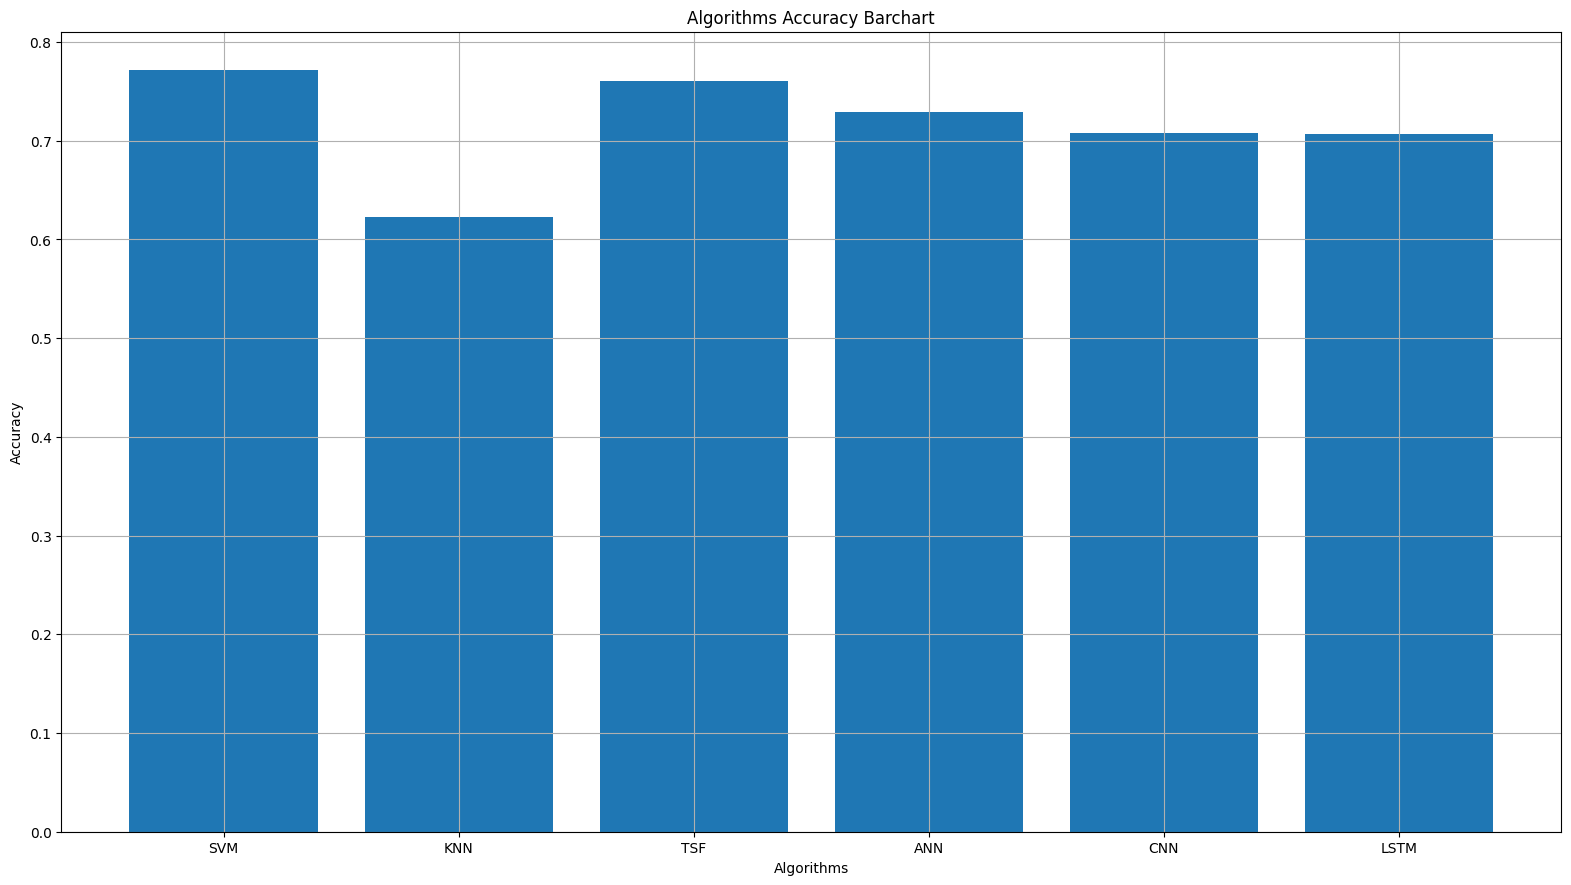

In [43]:
#Comparing Algorithms Accuracies using a barchart
fig = plt.figure(figsize=(15, 8), dpi=100)
ax = fig.add_axes([1,1,1,1])
Algos = ['SVM','KNN','TSF', 'ANN', 'CNN', 'LSTM']
Accs = [svm_acc,knn_acc,tsf_acc, dnn_performance[1], cnn_performance[1], lstm_performance[1]]
ax.bar(Algos,Accs);
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Algorithms Accuracy Barchart')

Text(0.5, 1.0, 'Algorithms Inference Time')

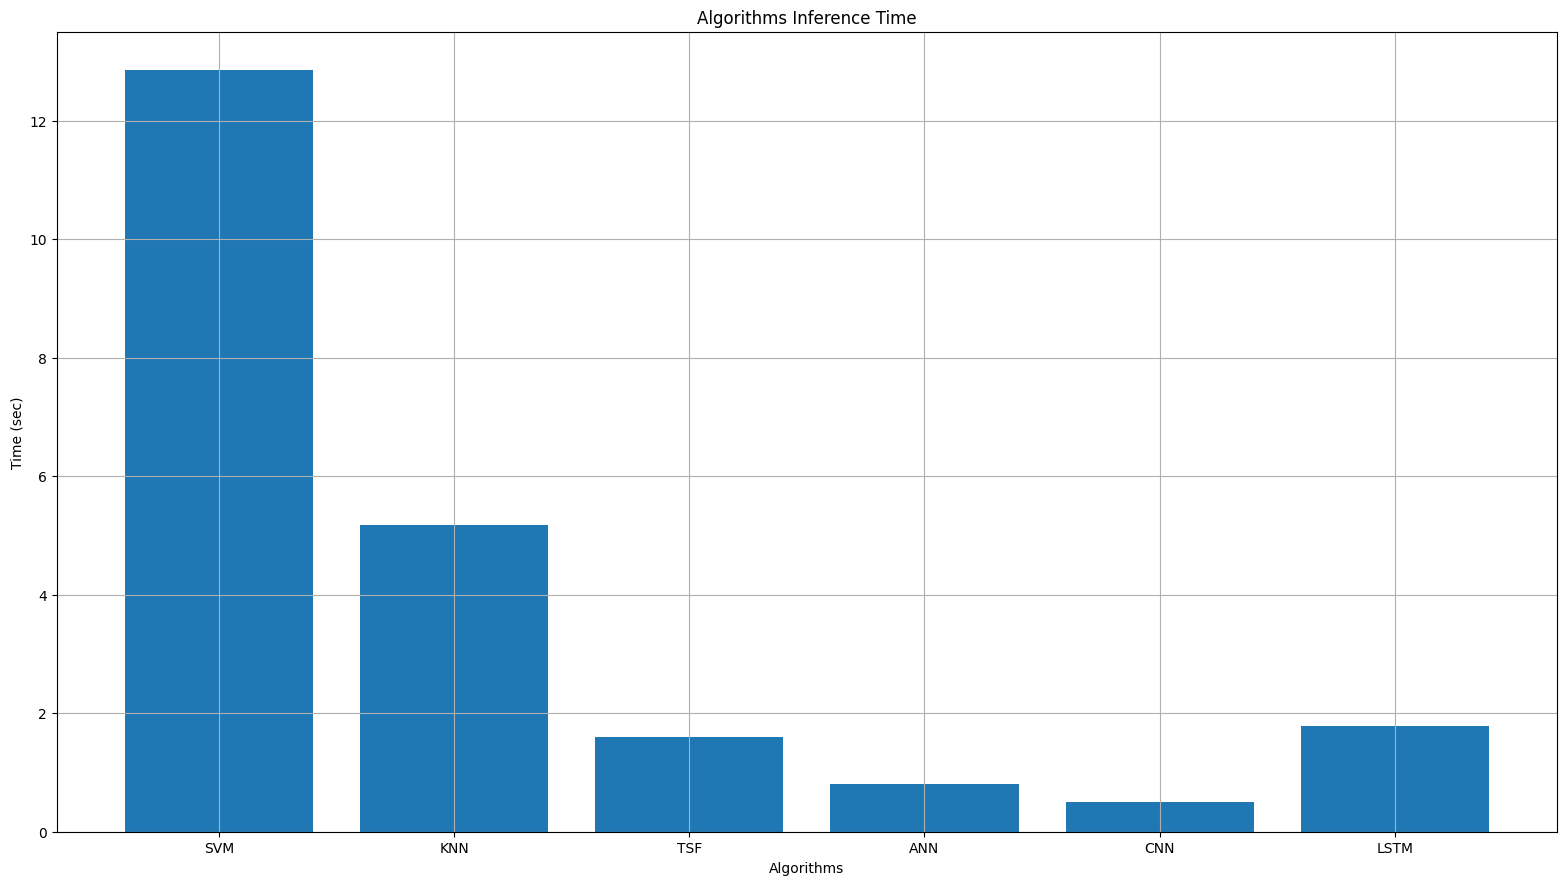

In [44]:
#Comparing Algorithms Inference time using a barchart
fig = plt.figure(figsize=(15, 8), dpi=100)
ax = fig.add_axes([1,1,1,1])
Algos = ['SVM','KNN','TSF', 'ANN', 'CNN', 'LSTM']
Accs = [svm_time,knn_time,tsf_time, dnn_time, cnn_time, lstm_time]
ax.bar(Algos,Accs);
plt.xlabel('Algorithms')
plt.ylabel('Time (sec)')
plt.grid()
plt.title('Algorithms Inference Time')

In [45]:
#Comparing algorithms accuracies and time using a table
from tabulate import tabulate      #For displaying results
table = [['Algorithm', 'Accuracy', 'Inference Time (sec)'], ['SVM', str(svm_acc),str(svm_time)], ['KNN', str(knn_acc),str(knn_time)], ['TSF', str(tsf_acc),str(tsf_time)], ['ANN', str(dnn_performance[1]),str(dnn_time)], ['CNN', str(cnn_performance[1]),str(cnn_time)], ['LSTM', str(lstm_performance[1]),str(lstm_time)]]

print(tabulate(table, headers='firstrow', tablefmt='grid'))

+-------------+------------+------------------------+
| Algorithm   |   Accuracy |   Inference Time (sec) |
+=============+============+========================+
| SVM         |   0.771871 |              12.8618   |
+-------------+------------+------------------------+
| KNN         |   0.62257  |               5.17407  |
+-------------+------------+------------------------+
| TSF         |   0.760936 |               1.60039  |
+-------------+------------+------------------------+
| ANN         |   0.729192 |               0.813266 |
+-------------+------------+------------------------+
| CNN         |   0.707928 |               0.498525 |
+-------------+------------+------------------------+
| LSTM        |   0.706713 |               1.7775   |
+-------------+------------+------------------------+
